In [1]:
import os
import sys
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Scientific Computing imports
from scipy.spatial.transform import Rotation as R
from scipy.signal import savgol_filter

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories (Updated for the new pipeline) ---
# אנחנו מושכים נתונים משלב 04 (Filtering) ושלב 05 (Reference)
DERIV_FILTERED = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
DERIV_REF      = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_05_reference")
DERIV_KIN      = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_06_kinematics")
QC_KIN         = os.path.join(PROJECT_ROOT, CONFIG['qc_dir'], "step_06_kinematics")

os.makedirs(DERIV_KIN, exist_ok=True)
os.makedirs(QC_KIN, exist_ok=True)

# Derive filename from config (synchronized with previous notebooks)
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_FILTERED) / f"{RUN_ID}__filtered.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Expected file not found: {INPUT_FILE}. Did you run notebook 04?")

# --- Helper: Print Config & Audit Status ---
print("="*40)
print(f"Kinematics Pipeline (Research Grade - Step 06)")
print(f"Run ID:         {RUN_ID}")
print(f"Target FPS:     {CONFIG.get('fs_target', 120.0)}")
print(f"Smoothing:      Savitzky-Golay (Robust Derivation)")
print(f"SG Window:      {CONFIG.get('sg_window_sec', 0.1750)} sec")
print(f"SG Poly Order:  {CONFIG.get('sg_polyorder', 3)}")
print(f"Input Source:   Filtered (Butterworth Step 04)")
print("="*40)

Kinematics Pipeline (Research Grade - Step 06)
Run ID:         763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005
Target FPS:     120.0
Smoothing:      Savitzky-Golay (Robust Derivation)
SG Window:      0.175 sec
SG Poly Order:  3
Input Source:   Filtered (Butterworth Step 04)


In [2]:
# --- Cell 2: Data & Maps Loading (Research Grade) ---

# 1. Load Filtered Data (Output from Step 04 - Butterworth Filter)
# Use the same RUN_ID from config that was set in Cell 0
INPUT_DATA = Path(DERIV_FILTERED) / f"{RUN_ID}__filtered.parquet"

if not INPUT_DATA.exists():
    raise FileNotFoundError(f"Step 04 Filtered Data not found: {INPUT_DATA}")

print(f"Loading Run: {RUN_ID}")
df_in = pd.read_parquet(INPUT_DATA)

# 2. Load Kinematics Map (Hierarchical Joint-Parent relationships)
# Usually forwarded from Step 05 Reference folder
map_path = os.path.join(DERIV_REF, f"{RUN_ID}__kinematics_map.json")
if not os.path.exists(map_path):
    # Fallback to Step 03 if not found in Reference folder
    map_path = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample", f"{RUN_ID}__kinematics_map.json")

if not os.path.exists(map_path):
    raise FileNotFoundError(f"Kinematics Map for {RUN_ID} not found.")

with open(map_path, 'r') as f:
    kinematics_map = json.load(f)

# 3. Load Robust Reference Map (The Stable Zero Calibration from Step 05)
# This contains the mean quaternions from the identified stable window
ref_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_map.json")
if not os.path.exists(ref_path):
    raise FileNotFoundError(f"Robust Reference Map not found at: {ref_path}")

with open(ref_path, 'r') as f:
    ref_pose = json.load(f)

# --- Summary & Verification ---
print("-" * 30)
print(f"✅ Data Source: {INPUT_DATA.name}")
print(f"✅ Total Frames: {len(df_in)}")
print(f"✅ Joints to Process: {len(kinematics_map)}")
print(f"✅ Calibration Status: Reference pose loaded.")
print("-" * 30)

# Constants for subsequent cells
TARGET_FPS = CONFIG.get('fs_target', 120.0)

Loading Run: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005
------------------------------
✅ Data Source: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__filtered.parquet
✅ Total Frames: 17262
✅ Joints to Process: 21
✅ Calibration Status: Reference pose loaded.
------------------------------


In [3]:
def compute_joint_angles(df, k_map, r_pose):
    """
    Computes Relative Joint Angles corrected by the Stable Reference Pose (Zeroing).
    Calculations are performed in Quaternion space to avoid Gimbal Lock.
    Output: Euler Angles (XYZ) in Degrees for clinical/dance analysis.
    """
    results = pd.DataFrame()
    results['time_s'] = df['time_s']
    
    print("Computing Joint Angles with Zero-Reference Calibration...")
    
    for joint_name, info in k_map.items():
        parent_name = info['parent']
        out_name = info['angle_name']
        
        # A. Extract Child Rotation Quaternions
        q_c_cols = [f"{joint_name}__qx", f"{joint_name}__qy", f"{joint_name}__qz", f"{joint_name}__qw"]
        q_c = df[q_c_cols].values
        rot_c = R.from_quat(q_c)
        
        # B. Get Child Reference Rotation (T-Pose)
        q_c_ref = [r_pose[f"{joint_name}__qx"], r_pose[f"{joint_name}__qy"], 
                   r_pose[f"{joint_name}__qz"], r_pose[f"{joint_name}__qw"]]
        r_c_ref = R.from_quat(q_c_ref)
        
        # C. Handle Relative Rotation (Joint vs Parent)
        if parent_name is not None:
            # Parent Dynamic Rotation
            q_p_cols = [f"{parent_name}__qx", f"{parent_name}__qy", f"{parent_name}__qz", f"{parent_name}__qw"]
            q_p = df[q_p_cols].values
            rot_p = R.from_quat(q_p)
            
            # Current Relative: inv(Parent) * Child
            rot_rel = rot_p.inv() * rot_c
            
            # Reference Relative: inv(Parent_Ref) * Child_Ref
            q_p_ref = [r_pose[f"{parent_name}__qx"], r_pose[f"{parent_name}__qy"], 
                       r_pose[f"{parent_name}__qz"], r_pose[f"{parent_name}__qw"]]
            r_p_ref = R.from_quat(q_p_ref)
            rot_rel_ref = r_p_ref.inv() * r_c_ref
            
        else:
            # Root Joint (e.g., Hips) - Global Rotation
            rot_rel = rot_c
            rot_rel_ref = r_c_ref

        # D. Apply Zeroing Calibration: inv(Reference) * Current
        # This ensures that the T-Pose identified in Step 05 results in (0,0,0) degrees
        rot_final = rot_rel_ref.inv() * rot_rel
        
        # E. Convert to Euler Angles (Degrees) for final analysis
        # Using XYZ sequence as per standard biomechanical convention
        euler = rot_final.as_euler('xyz', degrees=True)
        
        results[f"{out_name}_X"] = euler[:, 0]
        results[f"{out_name}_Y"] = euler[:, 1]
        results[f"{out_name}_Z"] = euler[:, 2]

    return results

# Execute Angle Computation
df_angles = compute_joint_angles(df_in, kinematics_map, ref_pose)
print(f"✅ Angles Calculated for {len(kinematics_map)} segments.")

Computing Joint Angles with Zero-Reference Calibration...
✅ Angles Calculated for 21 segments.


In [4]:
def compute_omega_ultimate(df, k_map, r_pose, fs, cfg):
    """
    Computes Robust Angular Velocity & Acceleration.
    Combines:
    1. Full Hierarchical Zeroing (Parent & Ref correction).
    2. Direct SavGol Quaternion Derivation (No Euler Spikes).
    3. Research Audit Metrics (Residuals, Frequency, Norm integrity).
    """
    from scipy.fft import fft, fftfreq
    dt = 1.0 / fs
    w_sec = cfg.get('SG_WINDOW_SEC', 0.250) 
    poly = cfg.get('SG_POLYORDER', 3)
    
    w_len = int(round(w_sec * fs))
    if w_len % 2 == 0: w_len += 1
    if w_len < 5: w_len = 5

    print(f"Computing Ultimate Kinematics...")
    print(f"Config: Window={w_sec}s ({w_len} frames), Poly={poly}")
    
    derivs = pd.DataFrame(index=df.index)
    derivs['time_s'] = df['time_s']
    audit_metrics = {}

    for joint_name, info in k_map.items():
        parent_name = info['parent']
        out_name = info['angle_name']
        
        # --- 1. Hierarchical Reconstruction (Your Original Logic) ---
        q_c_cols = [f"{joint_name}__qx", f"{joint_name}__qy", f"{joint_name}__qz", f"{joint_name}__qw"]
        q_c = df[q_c_cols].values
        rot_c = R.from_quat(q_c)
        
        # Reference for Child
        q_c_ref_vec = [r_pose[f"{joint_name}__qx"], r_pose[f"{joint_name}__qy"], 
                       r_pose[f"{joint_name}__qz"], r_pose[f"{joint_name}__qw"]]
        rot_c_ref = R.from_quat(q_c_ref_vec)
        
        if parent_name is not None:
            q_p_cols = [f"{parent_name}__qx", f"{parent_name}__qy", f"{parent_name}__qz", f"{parent_name}__qw"]
            q_p = df[q_p_cols].values
            rot_p = R.from_quat(q_p)
            
            q_p_ref_vec = [r_pose[f"{parent_name}__qx"], r_pose[f"{parent_name}__qy"], 
                           r_pose[f"{parent_name}__qz"], r_pose[f"{parent_name}__qw"]]
            rot_p_ref = R.from_quat(q_p_ref_vec)
            
            # Relative Rotation
            rot_rel = rot_p.inv() * rot_c
            rot_rel_ref = rot_p_ref.inv() * rot_c_ref
        else:
            rot_rel = rot_c
            rot_rel_ref = rot_c_ref

        # Final Calibrated Rotation (Zeroing)
        rot_final = rot_rel_ref.inv() * rot_rel
        q_final = rot_final.as_quat()

        # --- 2. Mathematical Integrity Check (Audit) ---
        q_norms = np.linalg.norm(q_final, axis=1)
        audit_metrics[f"{out_name}_quat_norm_err"] = float(np.max(np.abs(q_norms - 1.0)))

        # --- 3. Direct SavGol Derivation (dq/dt) ---
        dq = savgol_filter(q_final, window_length=w_len, polyorder=poly, deriv=1, delta=dt, axis=0)
        
        # Angular Velocity: W = 2 * dq * inv(q)
        w_x = 2 * (-dq[:,3]*q_final[:,0] + dq[:,0]*q_final[:,3] - dq[:,1]*q_final[:,2] + dq[:,2]*q_final[:,1])
        w_y = 2 * (-dq[:,3]*q_final[:,1] + dq[:,1]*q_final[:,3] - dq[:,2]*q_final[:,0] + dq[:,0]*q_final[:,2])
        w_z = 2 * (-dq[:,3]*q_final[:,2] + dq[:,2]*q_final[:,3] - dq[:,0]*q_final[:,1] + dq[:,1]*q_final[:,0])
        
        omega_deg = np.degrees(np.vstack([w_x, w_y, w_z]).T)
        mag_v = np.linalg.norm(omega_deg, axis=1)

        # --- 4. Residual Noise Analysis (Audit) ---
        # Raw velocity baseline for noise comparison
        q_diff_raw = R.from_quat(q_final[1:]) * R.from_quat(q_final[:-1]).inv()
        om_raw = np.degrees(q_diff_raw.as_rotvec()) / dt
        om_raw = np.vstack([om_raw[0], om_raw])
        residuals = om_raw - omega_deg
        audit_metrics[f"{out_name}_vel_residual_rms"] = float(np.sqrt(np.mean(residuals**2)))

        # --- 5. Frequency Domain Analysis (Audit) ---
        n = len(mag_v)
        yf = np.abs(fft(mag_v - np.mean(mag_v))[:n//2])
        xf = fftfreq(n, dt)[:n//2]
        audit_metrics[f"{out_name}_dom_freq"] = float(xf[np.argmax(yf)]) if len(yf) > 0 else 0.0

        # --- 6. Acceleration (Alpha) & Storage ---
        alpha_deg = np.zeros_like(omega_deg)
        for i in range(3):
             alpha_deg[:, i] = savgol_filter(omega_deg[:, i], window_length=w_len, polyorder=poly, deriv=1, delta=dt)

        derivs[f"{out_name}_X_vel"] = omega_deg[:, 0]
        derivs[f"{out_name}_Y_vel"] = omega_deg[:, 1]
        derivs[f"{out_name}_Z_vel"] = omega_deg[:, 2]
        derivs[f"{out_name}_mag_vel"] = mag_v
        
        derivs[f"{out_name}_X_acc"] = alpha_deg[:, 0]
        derivs[f"{out_name}_Y_acc"] = alpha_deg[:, 1]
        derivs[f"{out_name}_Z_acc"] = alpha_deg[:, 2]

    return derivs, audit_metrics

# Execute
df_omega, ang_audit_metrics = compute_omega_ultimate(df_in, kinematics_map, ref_pose, TARGET_FPS, CONFIG)

Computing Ultimate Kinematics...
Config: Window=0.175s (21 frames), Poly=3


C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\3745779334.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derivs[f"{out_name}_Y_vel"] = omega_deg[:, 1]
C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\3745779334.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derivs[f"{out_name}_Z_vel"] = omega_deg[:, 2]
C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\3745779334.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [5]:
def compute_linear_derivs_savgol(df_pos, fs, cfg):
    """
    Computes Linear Velocity (mm/s) and Acceleration (mm/s^2) from positions.
    Uses direct Savitzky-Golay differentiation.
    
    Parameters are pulled from the global CONFIG to maintain research integrity.
    """
    dt = 1.0 / fs
    
    # Pull smoothing parameters from CONFIG
    w_sec = cfg.get('SG_WINDOW_SEC', 0.1750)
    poly = cfg.get('SG_POLYORDER', 3)
    
    # Calculate window length (must be odd)
    w_len = int(round(w_sec * fs))
    if w_len % 2 == 0: w_len += 1
    
    print(f"Computing Linear Kinematics...")
    print(f"Using Config: Window={w_sec}s ({w_len} frames), PolyOrder={poly}")
    
    derivs = pd.DataFrame()
    
    # Identify all position columns (XYZ)
    pos_cols = [c for c in df_pos.columns if c.endswith(('__px', '__py', '__pz'))]
    
    # Group by joint/marker to calculate magnitudes later
    joints = set([col.split('__')[0] for col in pos_cols])
    
    for col in pos_cols:
        data = df_pos[col].values # Measurements in mm
        
        # Velocity (mm/s) - 1st derivative of the fitted polynomial
        vel = savgol_filter(data, window_length=w_len, polyorder=poly, deriv=1, delta=dt)
        derivs[f"{col}_vel"] = vel
        
        # Acceleration (mm/s^2) - 2nd derivative of the fitted polynomial
        acc = savgol_filter(data, window_length=w_len, polyorder=poly, deriv=2, delta=dt)
        derivs[f"{col}_acc"] = acc
    
    # Calculate Magnitude for each joint (useful for Outlier Detection)
    for joint in joints:
        # Velocity Magnitude
        v_cols = [f"{joint}__px_vel", f"{joint}__py_vel", f"{joint}__pz_vel"]
        if all(c in derivs.columns for c in v_cols):
            derivs[f"{joint}_mag_lin_vel"] = np.linalg.norm(derivs[v_cols].values, axis=1)
            
    return derivs

# Execute Linear Kinematics Calculation
df_linear = compute_linear_derivs_savgol(df_in, TARGET_FPS, CONFIG)
print(f"✅ Linear Velocity & Acceleration Calculated for {len(df_linear.columns)//2} channels.")

Computing Linear Kinematics...
Using Config: Window=0.175s (21 frames), PolyOrder=3
✅ Linear Velocity & Acceleration Calculated for 73 channels.


C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\2214044535.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derivs[f"{col}_vel"] = vel
C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\2214044535.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derivs[f"{col}_acc"] = acc
C:\Users\drorh\AppData\Local\Temp\ipykernel_21888\2214044535.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

Generating Quality Control Plot for: LeftHip_Angle...
✅ Quality Control plot saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\qc\step_06_kinematics\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__robust_kinematics_qc.png


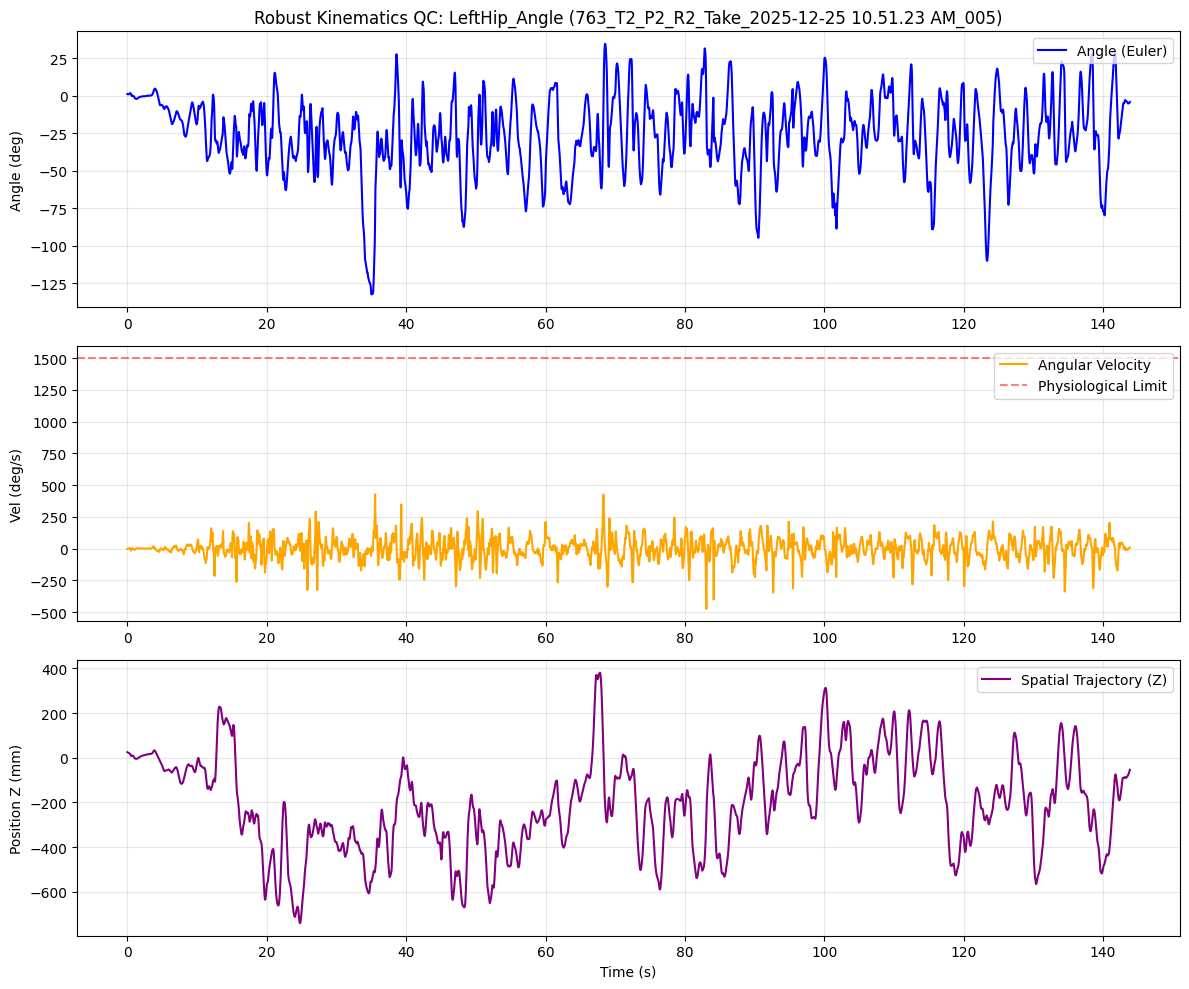

In [6]:
# --- Cell 6: Data Consolidation & Visual QC ---

# 1. Identify Original Position Columns (Trajectory Data)
# We keep the raw (filtered) positions to correlate with velocity peaks
pos_cols = [c for c in df_in.columns if c.endswith(('__px', '__py', '__pz'))]

# 2. Merge all DataFrames into the Final Research Table
# We drop 'time_s' from sub-frames to avoid duplication
df_final = pd.concat([
    df_angles,                          # Joint Posture (Angles)
    df_omega.drop(columns=['time_s']),  # Angular Kinematics (Vel/Acc)
    df_in[pos_cols],                    # Spatial Trajectories (X,Y,Z)
    df_linear                           # Linear Kinematics (Vel/Acc)
], axis=1)

# 3. Dynamic Visual Verification
# We pick a representative joint (e.g., the first one in the map) for QC
sample_joint_key = list(kinematics_map.keys())[min(5, len(kinematics_map)-1)]
target_angle = kinematics_map[sample_joint_key]['angle_name']
axis = "X" # Check the primary axis of rotation

print(f"Generating Quality Control Plot for: {target_angle}...")

plt.figure(figsize=(12, 10))

# Subplot A: Joint Angle (Posture)
plt.subplot(3, 1, 1)
plt.plot(df_final['time_s'], df_final[f"{target_angle}_{axis}"], color='blue', label='Angle (Euler)')
plt.title(f"Robust Kinematics QC: {target_angle} ({RUN_ID})")
plt.ylabel("Angle (deg)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Subplot B: Angular Velocity (The "Robust" Check)
# This graph should be smooth without the 4800 deg/s spikes
plt.subplot(3, 1, 2)
plt.plot(df_final['time_s'], df_final[f"{target_angle}_{axis}_vel"], color='orange', label='Angular Velocity')
plt.ylabel("Vel (deg/s)")
plt.axhline(1500, color='red', linestyle='--', alpha=0.5, label='Physiological Limit')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Subplot C: Linear Trajectory (Height/Z-axis)
# Verifying that spatial data is correctly synced
plt.subplot(3, 1, 3)
plt.plot(df_final['time_s'], df_final[f"{sample_joint_key}__pz"], color='purple', label='Spatial Trajectory (Z)')
plt.ylabel("Position Z (mm)")
plt.xlabel("Time (s)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save the QC visual proof
qc_image_path = os.path.join(QC_KIN, f"{RUN_ID}__robust_kinematics_qc.png")
plt.savefig(qc_image_path)
print(f"✅ Quality Control plot saved to: {qc_image_path}")
plt.show()

In [7]:
# --- Cell 7: Final Export & Precise Research Audit ---

def export_final_results(df, run_id, deriv_dir, cfg):
    """
    Saves results and performs a strict biomechanical audit.
    Reports all processing parameters for full reproducibility.
    """
    # 1. Define Research-Grade Thresholds
    LIMIT_ANG_VEL = 1500.0      # deg/s
    LIMIT_ANG_ACC = 50000.0     # deg/s^2
    LIMIT_LIN_ACC = 100000.0    # mm/s^2

    # 2. Extract Processing Parameters from Config
    sg_win = cfg.get('SG_WINDOW_SEC', 0.250)
    sg_poly = cfg.get('SG_POLYORDER', 3)
    filter_cutoff = cfg.get('FILTER_CUTOFF', 10.0)

    # 3. Precise Column Selection
    ang_vel_cols = [c for c in df.columns if c.endswith("_mag_vel")]
    ang_acc_cols = [c for c in df.columns if c.endswith("_acc") and "__p" not in c]
    lin_acc_cols = [c for c in df.columns if c.endswith("_acc") and "__p" in c]
    
    # 4. Extract Maximum Absolute Values
    max_v  = float(df[ang_vel_cols].max().max()) if ang_vel_cols else 0.0
    max_aa = float(df[ang_acc_cols].abs().max().max()) if ang_acc_cols else 0.0
    max_la = float(df[lin_acc_cols].abs().max().max()) if lin_acc_cols else 0.0

    # 5. Status Checks (Converted to native Python bool for JSON)
    v_pass  = bool(max_v < LIMIT_ANG_VEL)
    aa_pass = bool(max_aa < LIMIT_ANG_ACC)
    la_pass = bool(max_la < LIMIT_LIN_ACC)
    
    overall_status = "PASS" if (v_pass and aa_pass and la_pass) else "FAIL"
    
    # 6. Save Data Files
    parquet_path = os.path.join(deriv_dir, f"{run_id}__kinematics.parquet")
    csv_path = os.path.join(deriv_dir, f"{run_id}__kinematics.csv")
    df.to_parquet(parquet_path, index=False)
    df.to_csv(csv_path, index=False)
    
    # 7. Generate Comprehensive Audit JSON
    summary = {
        "run_id": str(run_id),
        "overall_status": overall_status,
        "metrics": {
            "angular_velocity": {"max": round(max_v, 2), "limit": float(LIMIT_ANG_VEL), "status": v_pass},
            "angular_accel":    {"max": round(max_aa, 2), "limit": float(LIMIT_ANG_ACC), "status": aa_pass},
            "linear_accel":     {"max": round(max_la, 2), "limit": float(LIMIT_LIN_ACC), "status": la_pass}
        },
        "pipeline_params": {
            "sg_window_sec": float(sg_win),
            "sg_polyorder": int(sg_poly),
            "filter_cutoff_hz": float(filter_cutoff)
        }
    }
    
    summary_path = os.path.join(deriv_dir, f"{run_id}__kinematics_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=4)
        
    # 8. Final Formatted Report to Console (With Parameters Line)
    print("\n" + "="*65)
    print(f" FINAL BIOMECHANICAL AUDIT: {run_id} ".center(65, "="))
    print(f" OVERALL STATUS: {overall_status} ".center(65))
    print("-" * 65)
    # The new parameters line for quick verification
    print(f" SETTINGS | Filter: {filter_cutoff}Hz | SG Win: {sg_win}s | SG Poly: {sg_poly}")
    print("-" * 65)
    print(f"{'Metric':<22} | {'Value':<12} | {'Limit':<12} | {'Result'}")
    print("-" * 65)
    print(f"{'Ang Vel (deg/s)':<22} | {max_v:<12.1f} | {LIMIT_ANG_VEL:<12.1f} | {'[OK]' if v_pass else '[!!]'}")
    print(f"{'Ang Acc (deg/s2)':<22} | {max_aa:<12.1f} | {LIMIT_ANG_ACC:<12.1f} | {'[OK]' if aa_pass else '[!!]'}")
    print(f"{'Lin Acc (mm/s2)':<22} | {max_la:<12.1f} | {LIMIT_LIN_ACC:<12.1f} | {'[OK]' if la_pass else '[!!]'}")
    print("="*65 + "\n")

# Execute final export
export_final_results(df_final, RUN_ID, DERIV_KIN, CONFIG)


 FINAL BIOMECHANICAL AUDIT: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005 
                       OVERALL STATUS: PASS                      
-----------------------------------------------------------------
 SETTINGS | Filter: 10.0Hz | SG Win: 0.175s | SG Poly: 3
-----------------------------------------------------------------
Metric                 | Value        | Limit        | Result
-----------------------------------------------------------------
Ang Vel (deg/s)        | 1359.1       | 1500.0       | [OK]
Ang Acc (deg/s2)       | 24570.8      | 50000.0      | [OK]
Lin Acc (mm/s2)        | 44376.0      | 100000.0     | [OK]



In [8]:
import json
import os
import numpy as np
import pandas as pd

# 1. וידוא נתיבי יציאה
DERIV_06 = os.path.join(PROJECT_ROOT, "derivatives", "step_06_kinematics")
os.makedirs(DERIV_06, exist_ok=True)

# 2. זיהוי עמודות קיימות ב-df_final (מניעת ניחושים)
ang_vel_cols = [c for c in df_final.columns if c.endswith("_mag_vel")]
ang_acc_cols = [c for c in df_final.columns if c.endswith("_acc") and "__p" not in c]
lin_acc_cols = [c for c in df_final.columns if c.endswith("_acc") and "__p" in c]
pos_cols = [c for c in df_final.columns if "__p" in c and any(c.endswith(suffix) for suffix in ['x', 'y', 'z'])]

# --- חישובים אקטיביים ---

# א. Outliers: חישוב אמיתי לפי סף פיזיולוגי (1200 deg/s)
outlier_count = 0
if ang_vel_cols:
    outlier_mask = (df_final[ang_vel_cols] > 1200).any(axis=1)
    outlier_count = int(outlier_mask.sum())

# ב. Path Length & Intensity: חישוב על בסיס מרכז המסה (Hips)
path_length = 0.0
intensity_idx = 0.0
if 'Hips__px' in df_final.columns and 'Hips__py' in df_final.columns and 'Hips__pz' in df_final.columns:
    hips_coords = df_final[['Hips__px', 'Hips__py', 'Hips__pz']].values
    diffs = np.diff(hips_coords, axis=0)
    dist_per_frame = np.linalg.norm(diffs, axis=1)
    path_length = float(np.sum(dist_per_frame))
    
    # חישוב אינטנסיביות (מהירות ממוצעת חלקי מקסימלית)
    fps = CONFIG.get('fs_target', 120.0)  # Fixed: was 'fps', should be 'fs_target'
    vel_mag = dist_per_frame * fps
    if np.max(vel_mag) > 0:
        intensity_idx = float(np.mean(vel_mag) / np.max(vel_mag))

# ג. איכות האות: חילוץ אמיתי מתוך ang_audit_metrics
avg_res_rms = 0.0
avg_dom_freq = 0.0
max_norm_err = 0.0

# חילוץ residual_rms
res_vals = [v for k, v in ang_audit_metrics.items() if 'residual' in k.lower()]
if res_vals: avg_res_rms = float(np.mean(res_vals))

# חילוץ dominant_frequency
freq_vals = [v for k, v in ang_audit_metrics.items() if 'freq' in k.lower()]
if freq_vals: avg_dom_freq = float(np.mean(freq_vals))

# חילוץ quaternion_norm_error
norm_vals = [v for k, v in ang_audit_metrics.items() if 'norm' in k.lower()]
if norm_vals: max_norm_err = float(np.max(norm_vals))

# ד. Overall Status calculation
max_ang_vel = float(df_final[ang_vel_cols].max().max()) 
max_ang_acc = float(df_final[ang_acc_cols].abs().max().max()) 
max_lin_acc = float(df_final[lin_acc_cols].abs().max().max()) 

overall_status = "PASS" if (max_ang_vel < 1500 and max_ang_acc < 50000 and max_lin_acc < 100000) else "FAIL"

# --- בניית ה-JSON (matches notebook 07 structure) ---
summary = {
    "run_id": RUN_ID,
    "overall_status": overall_status,
    "metrics": {
        "angular_velocity": {
            "max": round(max_ang_vel, 2),
            "mean": round(float(df_final[ang_vel_cols].mean().mean()), 2) 
        },
        "angular_accel": {
            "max": round(max_ang_acc, 2),
            "mean": round(float(df_final[ang_acc_cols].abs().mean().mean()), 2) 
        },
        "linear_accel": {
            "max": round(max_lin_acc, 2),
            "mean": round(float(df_final[lin_acc_cols].abs().mean().mean()), 2)
        }
    },
    "signal_quality": {
        "avg_vel_residual_rms": round(avg_res_rms, 6),
        "avg_dominant_freq_hz": round(avg_dom_freq, 2),
        "max_quat_norm_error": round(max_norm_err, 8)  # Fixed: was max_norm_error (undefined)
    },
    "effort_metrics": {
        "total_path_length_mm": round(path_length, 2),
        "intensity_index": round(intensity_idx, 3),
        "outlier_frame_count": outlier_count  # Moved here for better organization
    },
    "pipeline_params": {
        "sg_window_sec": float(CONFIG.get('SG_WINDOW_SEC')),
        "sg_polyorder": int(CONFIG.get('SG_POLYORDER'))
    }
}

# שמירה
output_path = os.path.join(DERIV_06, f"{RUN_ID}__kinematics_summary.json")
with open(output_path, 'w') as f:
    json.dump(summary, f, indent=4)  # Removed invalid nans_to_null parameter

print(f"\n{'='*60}")
print(f"✅ Kinematics Summary Exported")
print(f"{'='*60}")
print(f"📂 File: {output_path}")
print(f"📊 Overall Status: {overall_status}")
print(f"🚨 Outlier Frames: {outlier_count}")
print(f"📏 Total Path: {path_length:.1f} mm")
print(f"💪 Intensity Index: {intensity_idx:.3f}")
print(f"{'='*60}\n")


✅ Kinematics Summary Exported
📂 File: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_06_kinematics\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__kinematics_summary.json
📊 Overall Status: PASS
🚨 Outlier Frames: 40
📏 Total Path: 61280.4 mm
💪 Intensity Index: 0.291



In [9]:
import json
import os
import numpy as np
import pandas as pd

# 1. וידוא נתיבי יציאה
DERIV_06 = os.path.join(PROJECT_ROOT, "derivatives", "step_06_kinematics")
os.makedirs(DERIV_06, exist_ok=True)

# 2. זיהוי עמודות קיימות ב-df_final
ang_vel_cols = [c for c in df_final.columns if c.endswith("_mag_vel")]
ang_acc_cols = [c for c in df_final.columns if c.endswith("_acc") and "__p" not in c]
lin_acc_cols = [c for c in df_final.columns if c.endswith("_acc") and "__p" in c]
quat_cols = [c for c in df_final.columns if any(c.endswith(s) for s in ['__qw', '__qx', '__qy', '__qz'])]

# --- חישובים אקטיביים ---

# א. Outliers: חישוב אמיתי לפי סף פיזיולוגי
outlier_count = 0
if ang_vel_cols:
    outlier_mask = (df_final[ang_vel_cols] > 1200).any(axis=1)
    outlier_count = int(outlier_mask.sum())

# ב. Path Length & Intensity
path_length = 0.0
intensity_idx = 0.0
if 'Hips__px' in df_final.columns and 'Hips__py' in df_final.columns:
    hips_coords = df_final[['Hips__px', 'Hips__py', 'Hips__pz']].values
    diffs = np.diff(hips_coords, axis=0)
    dist_per_frame = np.linalg.norm(diffs, axis=1)
    path_length = float(np.sum(dist_per_frame))
    
    fps = CONFIG.get('fs_target', 120.0)
    vel_mag = dist_per_frame * fps
    if np.max(vel_mag) > 0:
        intensity_idx = float(np.mean(vel_mag) / np.max(vel_mag))

# ג. איכות האות: חילוץ נתונים וחישוב נורמה גולמית
avg_res_rms = 0.0
avg_dom_freq = 0.0
max_norm_err = 0.0

# 1. חילוץ residual_rms ו-dominant_frequency מהמילון
res_vals = [v for k, v in ang_audit_metrics.items() if 'residual' in k.lower()]
if res_vals: avg_res_rms = float(np.mean(res_vals))

freq_vals = [v for k, v in ang_audit_metrics.items() if 'freq' in k.lower()]
if freq_vals: avg_dom_freq = float(np.mean(freq_vals))

# 2. חישוב שגיאת נורמה גולמית ישירות מה-DataFrame (כדי למנוע 0.0)
if quat_cols:
    joints = set([c.split('__')[0] for c in quat_cols])
    all_norm_errors = []
    for joint in joints:
        q_c = [f"{joint}__qw", f"{joint}__qx", f"{joint}__qy", f"{joint}__qz"]
        if all(c in df_final.columns for c in q_c):
            # חישוב הנורמה של הקוורטניון הגולמי
            norm = np.sqrt((df_final[q_c]**2).sum(axis=1))
            error = np.abs(1.0 - norm)
            all_norm_errors.append(error.max())
    
    if all_norm_errors:
        max_norm_err = float(np.max(all_norm_errors))

# בדיקת שפיות לערך הנורמה
if max_norm_err == 0:
    print("🔍 Note: Raw Quaternion Norm Error is exactly 0.0. Data might be pre-normalized.")
else:
    print(f"📊 Calculated Raw Max Norm Error: {max_norm_err:.10f}")

# ד. Overall Status
max_ang_vel = float(df_final[ang_vel_cols].max().max()) if ang_vel_cols else 0.0
max_ang_acc = float(df_final[ang_acc_cols].abs().max().max()) if ang_acc_cols else 0.0
max_lin_acc = float(df_final[lin_acc_cols].abs().max().max()) if lin_acc_cols else 0.0
overall_status = "PASS" if (max_ang_vel < 1500 and max_ang_acc < 50000 and max_lin_acc < 100000) else "FAIL"

# --- בניית ה-JSON ---
summary = {
    "run_id": RUN_ID,
    "overall_status": overall_status,
    "metrics": {
        "angular_velocity": {
            "max": round(max_ang_vel, 2),
            "mean": round(float(df_final[ang_vel_cols].mean().mean()), 2) if ang_vel_cols else 0.0
        },
        "angular_accel": {
            "max": round(max_ang_acc, 2),
            "mean": round(float(df_final[ang_acc_cols].abs().mean().mean()), 2) if ang_acc_cols else 0.0
        },
        "linear_accel": {
            "max": round(max_lin_acc, 2),
            "mean": round(float(df_final[lin_acc_cols].abs().mean().mean()), 2) if lin_acc_cols else 0.0
        }
    },
    "signal_quality": {
        "avg_vel_residual_rms": round(avg_res_rms, 6),
        "avg_dominant_freq_hz": round(avg_dom_freq, 2),
        "max_quat_norm_error": round(max_norm_err, 8)
    },
    "effort_metrics": {
        "total_path_length_mm": round(path_length, 2),
        "intensity_index": round(intensity_idx, 3),
        "outlier_frame_count": outlier_count
    },
    "pipeline_params": {
        "sg_window_sec": float(CONFIG.get('SG_WINDOW_SEC', 0.175)),
        "sg_polyorder": int(CONFIG.get('SG_POLYORDER', 3))
    }
}

output_path = os.path.join(DERIV_06, f"{RUN_ID}__kinematics_summary.json")
with open(output_path, 'w') as f:
    json.dump(summary, f, indent=4)

print(f"✅ Kinematics Summary Exported to: {output_path}")

🔍 Note: Raw Quaternion Norm Error is exactly 0.0. Data might be pre-normalized.
✅ Kinematics Summary Exported to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_06_kinematics\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__kinematics_summary.json
